In [1]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import pandas as pd
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2)
plt.rc('hatch', color='black', linewidth=0.5)


warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results/remote'
REUSE_BASE = '/reuse'

SYSTEM_COLOR  = sns.color_palette()[0]
BASELINE_COLOR  = sns.color_palette()[1]
WRITE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results/reuse'

In [2]:
path = ROOT_RESULT_FOLDER+REUSE_BASE +'/same-workload/kaggle_home_credit/experiment_results.csv'
HEADERS = ['timestamp', 'exp_id', 'repo','script','rep','type','mat_rate','run_time']
reuse = pd.read_csv(path, header=None, names=HEADERS)


In [3]:
def plot_executions_reuse(df, loc=''):
    cat = sns.catplot(
        data=df,
        x='rep',
        y='run_time',
        hue='type',
        kind='bar',
        hue_order=['baseline', 'optimized'],
        palette={
            'optimized': SYSTEM_COLOR,
            'baseline': BASELINE_COLOR
        },
        legend=False)
 
    cat.set_axis_labels('Execution Number', 'Run Time (s)')
    
    num_executions = len(df.rep.unique())
    for i, bar in enumerate(cat.ax.patches):
        if i < num_executions:
            h = '//'
        else:
            h = '++'
        bar.set_edgecolor('black')
        bar.set_hatch(h)

    plt.gca().legend().set_title('')
    plt.legend(loc='upper right', labelspacing=-0.1)
    cat.savefig(loc)

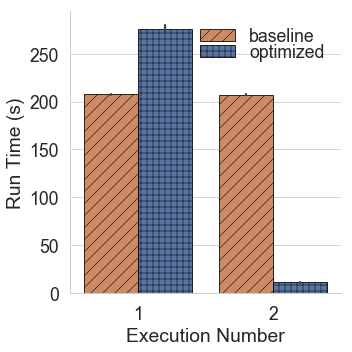

In [4]:
df = reuse[reuse['script'] == 'introduction_to_manual_feature_engineering']
df = df[~((df['rep'] == 2) & (df['mat_rate'] == 0.0) &  (df['type'] == 'optimized'))]
plot_executions_reuse(df, WRITE_DIRECTORY+'/kaggle-repeated-workloads/introduction_to_manual_feature_engineering.pdf')

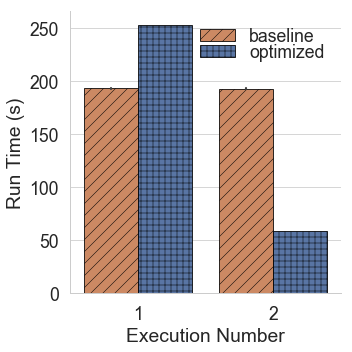

In [5]:
df = reuse[reuse['script'] == 'start_here_a_gentle_introduction']
df = df[~((df['rep'] == 2) & (df['mat_rate'] == 0.0) &  (df['type'] == 'optimized'))]
plot_executions_reuse(df, WRITE_DIRECTORY+'/kaggle-repeated-workloads/start_here_a_gentle_introduction.pdf')

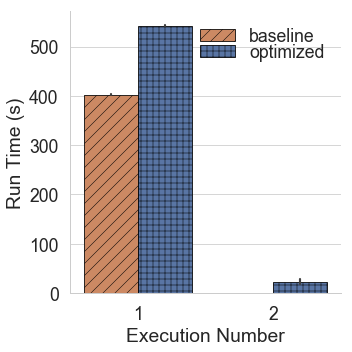

In [6]:
df = reuse[reuse['script'] == 'introduction_to_manual_feature_engineering_p2']
df = df[~((df['rep'] == 2) & (df['mat_rate'] == 0.0) &  (df['type'] == 'optimized'))]
plot_executions_reuse(df, WRITE_DIRECTORY+'/kaggle-repeated-workloads/introduction_to_manual_feature_engineering_p2.pdf')